#Red de  amistad
#Descripción de la red

In [2]:
#Carga librerías importantes
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import operator
import pip
import csv
import pickle
import operator
import random as rd
pip.main(['install','python-louvain'])
import community
from collections import Counter
import itertools

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pylab as pl
from sklearn import metrics



In [11]:
#Create empty network

g= nx.Graph()
#read nodes
nodes= csv.reader(open('./Nodos_Amigos.csv'))
next(nodes,None)

for row in nodes:
    g.add_node(row[0])  
    g.node[row[0]]['sexo']=row[1]
    g.node[row[0]]['raza']=row[2]
    g.node[row[0]]['grado']=row[3]
    g.node[row[0]]['escuela']=row[4]
    
#read edges
edges=csv.reader(open('./Arcos_Amigos.csv'))

next(edges,None)

for row in edges:
    g.add_edge(row[0],row[1])
    g.edge[row[0]][row[1]]['weight']=int(float(row[2]))
    #print(g.edge[row[0]][row[1]]['weight'])

print('La red tiene ',g.number_of_nodes(),'nodos y ',g.number_of_edges(),'arcos')


La red tiene  2209 nodos y  7987 arcos


In [24]:
##############################GRADO PROMEDIO ###########################################################
grado=g.degree()
grado_promedio_simple= sum(grado.values())/g.number_of_nodes()
print('El grado promedio de la red  es: ', grado_promedio_simple)

grado_p=g.degree(weight='weight')
grado_promedio_p= sum(grado.values())/g.number_of_nodes()
print('El grado promedio ponderado de la red  es: ', grado_promedio_p)

################################CLUSTERING PROMEDIO##########################################################

#patrones
trans=nx. average_clustering(g)
print('La transitividad promedio simple en la red es:',trans)

trans_p=nx. average_clustering(g,weight='weight')
print('La transitividad promedio ponderada en la red es:',trans_p)

##############################DIAMETRO##########################################################

maximo_conectado=max(nx.connected_component_subgraphs(g),key=len)
diametro_sg=nx.diameter(maximo_conectado)
print('El diámetro del subgrafo más conectado es:',diametro_sg)

##############################DENSIDAD###################################################################

densidad= nx.density(g)
print('La densidad de la red es:', densidad)

##############################MODULARIDAD##############################################################
partition=community.best_partition(g)
for n in g.nodes() :
     g.node[n]['comunidad']= partition[n]

valores=[partition.get(node) for node in g.nodes()]
comunidades=set([v for (k,v) in partition.items() ])

print('la red tiene',len(comunidades), 'coumunidades')

print('la modularidad de la red es', community.modularity(partition,g))

#nx.draw_networkx(g, cmap=plt.get_cmap('jet'),node_color=valores,
#                 node_size=30,with_labels=False)
#plt.show()
nx.write_graphml(g, "./amistades.graphml")

El grado promedio de la red  es:  7.231326392032594
El grado promedio ponderado de la red  es:  7.231326392032594
La transitividad promedio simple en la red es: 0.18189446691554828
La transitividad promedio ponderada en la red es: 0.08097589191429651
El diámetro del subgrafo más conectado es: 11
La densidad de la red es: 0.003275057242768385
la red tiene 74 coumunidades
la modularidad de la red es 0.7245955462242482


In [12]:
#Homofilia
# función que calcula probabilidad de relaciones MM, MH e HH en Red original
NH=0
NM=0
NN=0

def prob_relaciones(g):
    RMM=0
    RMH=0
    RHH=0

    for e in g.edges() :

        if not g.node[e[0]]['sexo']==g.node[e[1]]['sexo']:
            RMH=RMH+1
        else:
            if g.node[e[0]]['sexo']== '1':
                RHH=RHH+1
            if g.node[e[0]]['sexo']== '2':
                RMM=RMM+1
    PMM=RMM/g.number_of_edges()        
    PMH=RMH/g.number_of_edges()        
    PHH=RHH/g.number_of_edges()
    return PMM,PMH,PHH

PMM_O=(prob_relaciones(g)[0])
PMH_O=(prob_relaciones(g)[1])
PHH_O=(prob_relaciones(g)[2])

for n in g.nodes() :
    if g.node[n]['sexo']=='1':
        NH+=1
    if g.node[n]['sexo']=='2':
        NM+=1
    if g.node[n]['sexo']=='0':
        NN+=1

PH=NH/g.number_of_nodes()
PM=NM/g.number_of_nodes()
PN=NN/g.number_of_nodes()

print('Probabilidad observada  de relación MM: ',PMM_O,'Probabilidad observada  de relación MH: ',
      PMH_O,'Probabilidad observada  de relación HH: ',PHH_O, 'Probabilidad de hombre: ',PH,
      'Probabilidad de mujer: ',PM,'Probabilidad de NA: ',PN) 

#cálculo de grado promedio en red original por sexo
sexo=set([v['sexo'] for (k,v) in g.node.items() ])
grado_sexo=[]
tol_min={}
tol_max={}
for s in sexo:
    nodos_sexo=[]
    for i in range(len(g.nodes())):
        if (g.node[g.nodes()[i]]['sexo']== s):
            nodos_sexo.append(g.nodes()[i])
    grado=g.degree(nodos_sexo)
    valores=sum(grado.values())/g.number_of_nodes()
    grado_sexo.append((s,valores))
    tol_max[s]=valores*1.1
    tol_min[s]=valores*0.9
    

                      
#print(grado_sexo,tol_max,tol_min)



Probabilidad observada  de relación MM:  0.2927256792287467 Probabilidad observada  de relación MH:  0.4609991235758107 Probabilidad observada  de relación HH:  0.24602479028421184 Probabilidad de hombre:  0.49117247623358984 Probabilidad de mujer:  0.4938886373924853 Probabilidad de NA:  0.014938886373924853


In [15]:
PMM_ratio=[]
PMH_ratio=[]
PHH_ratio=[]

for i in range (1000):
    g1=g
    grado_sexo={}
    cumple_tol=0
    #Dar valor del atributo sexo a cada nodo de manera aleatoria respetando las probabilidades de la red original
    for n in g1.nodes() :
        #print('previo: ',g1.node[n]['sexo'])
        nrd=rd.random()
        #print(nrd)
        if nrd<=PN :
            g1.node[n]['sexo']='0'
        if nrd>PN and nrd<=PN+PH:
            g1.node[n]['sexo']='1'
        if nrd>=PN+PH:
            g1.node[n]['sexo']='2'
        #print('posterior: ',g1.node[n]['sexo'])
     #verificar si la tolerancia de grado promedio se cumple   
    for s in sexo:
        nodos_sexo=[]
        for i in range(len(g1.nodes())):
            if (g1.node[g1.nodes()[i]]['sexo']== s):
                nodos_sexo.append(g1.nodes()[i])
        grado=g1.degree(nodos_sexo)
        grado_s=sum(grado.values())/g1.number_of_nodes()
        #print(grado_s)
        grado_sexo[s]=grado_s
        if(grado_sexo[s]>=tol_min[s] and grado_sexo[s]<=tol_max[s]):
            cumple_tol+=1

    if(cumple_tol==3):
        PMM_ratio.append(PMM_O/prob_relaciones(g1)[0])
        PMH_ratio.append(PMH_O/prob_relaciones(g1)[1])
        PHH_ratio.append(PHH_O/prob_relaciones(g1)[2])

    

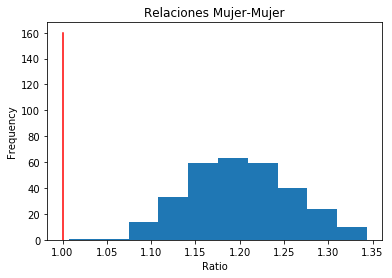

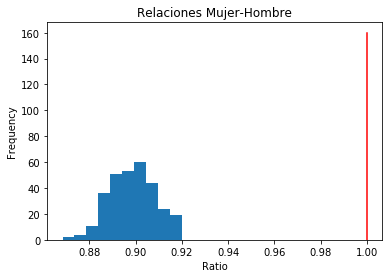

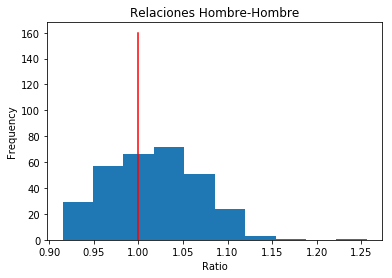

(0.9909744262695312, 0.058989591896533966)
(0.9929805994033813, 0.16531193256378174)
(0.9819090366363525, 0.0006953381816856563)


In [16]:
plt.hist(PMM_ratio)
plt.plot((1, 1), (0, 160), 'r')
plt.title("Relaciones Mujer-Mujer")
plt.xlabel("Ratio")
plt.ylabel("Frequency")
plt.show()

plt.hist(PMH_ratio)
plt.plot((1, 1), (0, 160), 'r')
plt.title("Relaciones Mujer-Hombre")
plt.xlabel("Ratio")
plt.ylabel("Frequency")
plt.show()

plt.hist(PHH_ratio)
plt.plot((1, 1), (0, 160), 'r')
plt.title("Relaciones Hombre-Hombre")
plt.xlabel("Ratio")
plt.ylabel("Frequency")
plt.show()

print(stats.shapiro(PMM_ratio))
print(stats.shapiro(PMH_ratio))
print(stats.shapiro(PHH_ratio))



# homofilia entre escuelas

In [17]:
#Homofilia
# función que calcula probabilidad de relaciones MM, MH e HH en Red original
N0=0
N1=0

def prob_relaciones(g):
    R00=0
    R01=0
    R11=0

    for e in g.edges() :

        if not g.node[e[0]]['escuela']==g.node[e[1]]['escuela']:
            R01+=1
        else:
            if g.node[e[0]]['escuela']== '1':
                R11=R11+1
            if g.node[e[0]]['sexo']== '0':
                R00=R00+1
    P00=R00/g.number_of_edges()        
    P01=R01/g.number_of_edges()        
    P11=R11/g.number_of_edges()
    return P00,P01,P11

P00_O=(prob_relaciones(g)[0])
P01_O=(prob_relaciones(g)[1])
P11_O=(prob_relaciones(g)[2])

for n in g.nodes() :
    if g.node[n]['escuela']=='1':
        N1+=1
    if g.node[n]['escuela']=='0':
        N0+=1

P0=N0/g.number_of_nodes()
P1=N1/g.number_of_nodes()

print('Probabilidad observada  de relación entre  estudiantes de la escuela 0: ',P00_O,'Probabilidad observada  de relación de diferentes escuelas: ',
      P01_O,'Probabilidad observada  de relación de estudiantes de la escuela 1: ',P11_O, 'Probabilidad de ser de escuela 0: ',P0,
      'Probabilidad de ser de la escuela 1: ',P1) 

#cálculo de grado promedio en red original por sexo
escuela=set([v['escuela'] for (k,v) in g.node.items() ])
grado_e=[]
tol_min={}
tol_max={}
for e in escuela:
    nodos_e=[]
    for i in range(len(g.nodes())):
        if (g.node[g.nodes()[i]]['escuela']== e):
            nodos_e.append(g.nodes()[i])
    grado=g.degree(nodos_e)
    valores=sum(grado.values())/g.number_of_nodes()
    grado_e.append((e,valores))
    tol_max[e]=valores*1.1
    tol_min[e]=valores*0.9
    

                      
#print(grado_sexo,tol_max,tol_min)


Probabilidad observada  de relación entre  estudiantes de la escuela 0:  0.012395142105922123 Probabilidad observada  de relación de diferentes escuelas:  0.018279704519844748 Probabilidad observada  de relación de estudiantes de la escuela 1:  0.7820207837736322 Probabilidad de ser de escuela 0:  0.17609778180172023 Probabilidad de ser de la escuela 1:  0.8239022181982798


In [21]:
P00_ratio=[]
P01_ratio=[]
P11_ratio=[]

for i in range (1000):
    g1=g
    grado_escuela={}
    cumple_tol=0
    #Dar valor del atributo sexo a cada nodo de manera aleatoria respetando las probabilidades de la red original
    for n in g1.nodes() :
        #print('previo: ',g1.node[n]['sexo'])
        nrd=rd.random()
        #print(nrd)
        if nrd<=P0 :
            g1.node[n]['escuela']='0'
        if nrd>P0 :
            g1.node[n]['escuela']='1'
        #print('posterior: ',g1.node[n]['sexo'])
     #verificar si la tolerancia de grado promedio se cumple   
    for e in escuela:
        nodos_escuela=[]
        for i in range(len(g1.nodes())):
            if (g1.node[g1.nodes()[i]]['escuela']== e):
                nodos_escuela.append(g1.nodes()[i])
        grado=g1.degree(nodos_escuela)
        grado_e=sum(grado.values())/g1.number_of_nodes()
        #print(grado_s)
        grado_escuela[e]=grado_e
        if(grado_escuela[e]>=tol_min[e] and grado_escuela[e]<=tol_max[e]):
            cumple_tol+=1

    if(cumple_tol==2):
        P00_ratio.append(P00_O/prob_relaciones(g1)[0])
        P01_ratio.append(P01_O/prob_relaciones(g1)[1])
        P11_ratio.append(P11_O/prob_relaciones(g1)[2])


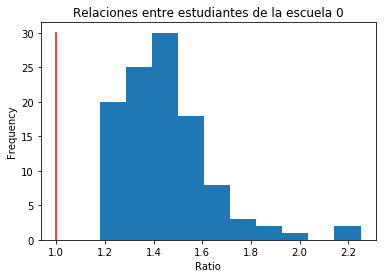

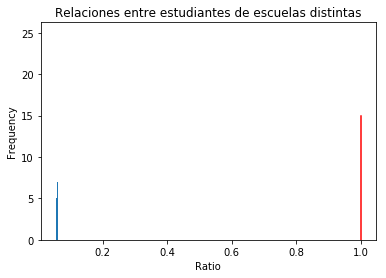

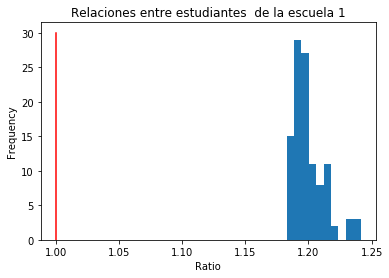

(0.8820861577987671, 8.335388201885507e-08)
(0.9818947911262512, 0.14529575407505035)
(0.8873186111450195, 1.4340407972213143e-07)


In [19]:
plt.hist(P00_ratio)
plt.plot((1, 1), (0, 30), 'r')
plt.title("Relaciones entre estudiantes de la escuela 0")
plt.xlabel("Ratio")
plt.ylabel("Frequency")
plt.show()

plt.hist(P01_ratio)
plt.plot((1, 1), (0, 15), 'r')
plt.title("Relaciones entre estudiantes de escuelas distintas")
plt.xlabel("Ratio")
plt.ylabel("Frequency")
plt.show()

plt.hist(P11_ratio)
plt.plot((1, 1), (0, 30), 'r')
plt.title("Relaciones entre estudiantes  de la escuela 1")
plt.xlabel("Ratio")
plt.ylabel("Frequency")
plt.show()

print(stats.shapiro(P00_ratio))
print(stats.shapiro(P01_ratio))
print(stats.shapiro(P11_ratio))

 #Normalized Mutual Information coefficient

In [23]:
#NMI para sexo
nodos_comunidad=[v['comunidad'] for (k,v) in g.node.items() ]
nodos_sexo=[v['sexo'] for (k,v) in g.node.items() ]
nodos_raza=[v['raza'] for (k,v) in g.node.items() ]
nodos_escuela=[v['escuela'] for (k,v) in g.node.items() ]
nodos_grado=[v['grado'] for (k,v) in g.node.items() ]

print('El valor del NMI score para escuela y comunidad es: ', metrics.normalized_mutual_info_score(nodos_comunidad, nodos_escuela))
print('El valor del NMI score para sexo y comunidad es: ',metrics.normalized_mutual_info_score(nodos_comunidad, nodos_sexo))
print('El valor del NMI score para raza y comunidad es: ',metrics.normalized_mutual_info_score(nodos_comunidad, nodos_raza))
print('El valor del NMI score para grado y comunidad es: ',metrics.normalized_mutual_info_score(nodos_comunidad, nodos_grado))
    

KeyError: 'comunidad'

# Modularidad

In [25]:

comunidades= set([v['comunidad'] for (k,v) in g.node.items() ])
contador= {}
modu_intracomunidad={}
gc=nx.Graph()

#Modularidad inter  comunidades
for k,v in partition.items():
    contador[v] = contador.get(v,0) + 1


for e in g.edges() :
    if not g.node[e[0]]['comunidad']==g.node[e[1]]['comunidad']:
        if not(gc.has_edge(g.node[e[0]]['comunidad'],g.node[e[1]]['comunidad'])):
            gc.add_edge(g.node[e[0]]['comunidad'],g.node[e[1]]['comunidad'])
#print(gc.edges())
            gc.edge[g.node[e[0]]['comunidad']][g.node[e[1]]['comunidad']]['weight']=1
        else:
            gc.edge[g.node[e[0]]['comunidad']][g.node[e[1]]['comunidad']]['weight']+=1
        
partition_c= community.best_partition(gc)

modu_comunidad=community.modularity(partition_c,gc)

print(modu_comunidad )

#Modularidad entre comunidad

for c in comunidades:
    nodos_c=[]
    for i in range(len(g.nodes())):
        if (g.node[g.nodes()[i]]['comunidad']== c):
            nodos_c.append(g.nodes()[i])
            #print(nodos_casa)
    if(len(nodos_c)>1):
        sg=g.subgraph(nodos_c)
        partition_sg= community.best_partition(sg)
        modu_intracomunidad[c]=community.modularity(partition_sg,sg)
print(modu_intracomunidad)
    


0.1811668096941047
{0: 0.7080550781249998, 1: 0.7219492502883508, 3: 0.5581382912947137, 4: 0.6464350874221467, 6: 0.5773873976969592, 7: 0.6677169681995245, 8: 0.6318493834007948, 9: 0.5602027500597395, 10: 0.6192673885177504, 11: 0.7277611989994464, 12: 0.6272905960156426, 13: 0.688036896001339, 14: 0.649431497467381, 15: 0.5122146087882187, 17: 0.6442554012345679, 18: 0.5693547872436359, 20: 0.7105034722222223, 21: 0.43960858452372803, 39: 0.0}


In [26]:
print(comunidades)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73}
